In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from keras.models import Model
from keras import backend as K
from keras import Input
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D

from tqdm import tqdm

%matplotlib inline

In [ ]:
def show3D(builds, binary=True, textArr=None):
    fig = plt.figure(figsize=(20,7))
    col = 8
    
    if binary:
        colors = 'red'
    else:
        colors = 'red' #replace later with colors for each block id value [0-12]
    
    for i, build in enumerate(builds):
        ax = fig.add_subplot(int(len(builds) / col) + 1, col, i + 1,  projection='3d')
        ax.voxels(build, edgecolor="k", facecolors=colors, linewidth=0.5)
        plt.axis('off')
        if textArr != None:
            plt.title(textArr[i])
    plt.show()

In [ ]:
def cropHouse(h):
    # argwhere will give you the coordinates of every non-zero point
    true_points = np.argwhere(h)
    # take the smallest points and use them as the top left of your crop
    top_left = true_points.min(axis=0)
    # take the largest points and use them as the bottom right of your crop
    bottom_right = true_points.max(axis=0)
    out = h[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
              top_left[1]:bottom_right[1]+1,top_left[2]:bottom_right[2]+1]  # inclusive
    
    return out

def houseTrans(h,s=(16,16,16)):
    hts = []
    s2 = cropHouse(h)
    s2s = s2.shape
    ds = (s[0]-s2s[0],s[1]-s2s[1],s[2]-s2s[2])
    RATE = 2
    #print(ds)
    #for x in range(1):
    for x in range(0,s[0]-s2s[0]+1,RATE):
        #for y in range(1):
        for y in range(0,s[1]-s2s[1],RATE):
            for z in range(1):
            #for z in range(s[2]-s2s[2]+1):
                thouse = np.zeros(shape=s)
                thouse[x:x+s2s[0],y:y+s2s[1],z:z+s2s[2]] = s2.copy()
                hts.append(thouse)
    return hts

In [ ]:
HOUSE_DATASET = []
HOUSE_DATASET_BIN = []
DOUBLE_HOUSES = []
DOUBLE_MOVE_HOUSES = []
TRANS_HOUSES = []
TRANS_HOUSES_PRE = []
TRANS_DOUBLE_HOUSES = []

house_combined = np.load('combined.npy')
blocks = []
with tqdm(total=len(house_combined)) as pbar:
    for h in house_combined:
        # houses look rotated... just rotate them back
        h = np.rot90(h,axes=(0,2))
        
        # remove bottom layer (got the ground as well) - i can't believe i got it right on the first try...
        h = h[3:, 3:, 1:-2]
        #HOUSE_DATASET.append(h)
        
        #binary
        idx = np.nonzero(h)
        hb = np.zeros(shape=h.shape)
        for i in range(len(idx[0])):
            a,b,c = idx
            hb[a[i]][b[i]][c[i]] = 1
        #HOUSE_DATASET_BIN.append(hb)

        #crop and translate
        tds = []
        #for di in HOUSE_DATASET_BIN:
        tds = houseTrans(hb,(16,16,16))
        #print(len(tds))
        # TRANS_DOUBLE_HOUSES += random.choices(tds,k=20)
        #TRANS_HOUSES_PRE += tds

        #rotated
        trans_rot_set = []
        for haus in tds:
          trans_rot_set.append(haus)
          trans_rot_set.append(np.rot90(haus,axes=(0,1)))
          trans_rot_set.append(np.rot90(haus,axes=(1,0)))
          trans_rot_set.append(np.rot90(np.rot90(haus,axes=(1,0)),axes=(1,0)))


        #doubled binary
        # h2 = hb
        # dh = np.zeros(shape=(32,32,32))
        # m = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1),(1,1,1)]
        # for x in range(16):
        #     for y in range(16):
        #         for z in range(16):
        #             v = h2[x][y][z]
        #             if v == 0:
        #                 continue
        #             for mi in m:
        #                 dh[x*2+mi[0]][y*2+mi[1]][z*2+mi[2]] = v
        # DOUBLE_HOUSES.append(dh)

        #doubled binary from translated houses
        for h2 in trans_rot_set:
          dh = np.zeros(shape=(32,32,32))
          m = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1),(1,1,1)]
          for x in range(16):
              for y in range(16):
                  for z in range(16):
                      v = h2[x][y][z]
                      if v == 0:
                          continue
                      for mi in m:
                          dh[x*2+mi[0]][y*2+mi[1]][z*2+mi[2]] = v
          TRANS_DOUBLE_HOUSES.append(dh)

        #doubled binary and rotated
        # hi = np.copy(dh)
        # DOUBLE_MOVE_HOUSES.append(hi)
        # DOUBLE_MOVE_HOUSES.append(np.rot90(hi,axes=(0,1)))
        # DOUBLE_MOVE_HOUSES.append(np.rot90(hi,axes=(1,0)))
        # DOUBLE_MOVE_HOUSES.append(np.rot90(np.rot90(hi,axes=(1,0)),axes=(1,0)))

        pbar.update(1)

    
        
#HOUSE_DATASET = np.array(HOUSE_DATASET)
#HOUSE_DATASET_BIN = np.array(HOUSE_DATASET_BIN)
#DOUBLE_HOUSES = np.array(DOUBLE_HOUSES)
#DOUBLE_MOVE_HOUSES = np.array(DOUBLE_MOVE_HOUSES)
TRANS_DOUBLE_HOUSES = np.array(TRANS_DOUBLE_HOUSES)
#TRANS_HOUSES = np.array(TRANS_HOUSES)

100%|██████████| 144/144 [00:50<00:00,  2.85it/s]


10740


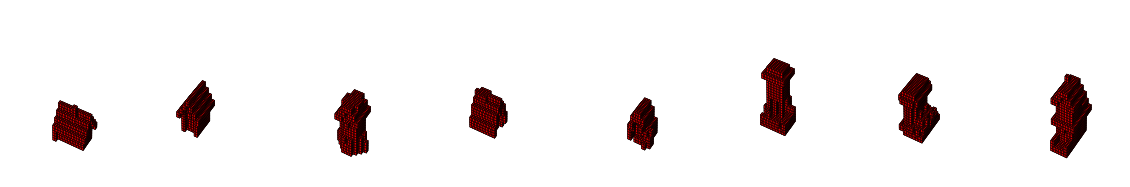

In [ ]:
X_TRAIN = TRANS_DOUBLE_HOUSES

print(len(X_TRAIN))

# show a few random ones to verify
show3D(X_TRAIN[random.choices(list(range(len(X_TRAIN))),k=8)])

### VAE Reimplementation


### vae #1

In [ ]:
'''
from IPython.lib.display import YouTubeVideo
from keras.models import Model
from keras import backend as K
from keras import Input
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon
    

class VAE(Model):
    def __init__(self,zshape,batches=1,channels=1):
        super(VAE, self).__init__()
        
        self.channels = channels
        self.latent_dim = zshape
        self.batch_size = batches
        self.nn_size = 32
        
        #make the models
        self.makeEncoder()
        self.makeDecoder()
        
    #makes the encoder model for the VAE
    def makeEncoder(self):
        
        #variational encoder
        # enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        # x = Conv3D(16, kernel_size=5, padding='same', activation='relu')(enc_in)
        # x = MaxPooling3D((2, 2, 2), padding='same')(x)
        # x = Conv3D(32, kernel_size=5, padding='same', activation='relu')(x)
        # x = MaxPooling3D((2, 2, 2), padding='same')(x)
        enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        x = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(enc_in)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(x)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Flatten()(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if DEBUG:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        y = Dense(30720, activation="relu")(dec_in)  #product of output shape of autoencoder
        y = Reshape((8,8,8,60))(y)  #output shape of autoencoder
        
        
        # y = Conv3D(32, kernel_size=5, activation='relu', padding='same')(y)
        # y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        # y = Conv3D(16, kernel_size=5, activation='relu', padding='same')(y)
        # y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        # dec_out = Conv3D(1, kernel_size=5, activation='relu', padding='same')(y)

        y = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(y)
        y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        y = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(y)
        y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        dec_out = Conv3D(1, (5, 5, 5), activation='relu', padding='same')(y)    

        self.decoder = Model(dec_in, dec_out)

        
        if DEBUG:
            self.decoder.summary()
     
    #define loss functions
    
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
#         return K.mean(K.square(tf.cast(y_true,tf.float32) - tf.cast(y_pred,tf.float32)), axis = [1,2,3])
        return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2,3)))
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
#         return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1)))
        return kl_loss
    
    #singular step for training
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - MSE + KL DIVERGENCE
            reconstruction_loss = self.r_loss(data,reconstruction)
            kl = self.kl_loss(z_log_var,z_mean)
            #tl = 10000*reconstruction_loss+kl
            tl = reconstruction_loss+kl

            print(tl)
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}

'''

'\nfrom IPython.lib.display import YouTubeVideo\nfrom keras.models import Model\nfrom keras import backend as K\nfrom keras import Input\nfrom keras import Sequential\nfrom keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D\n\nclass Sampling(tf.keras.layers.Layer):\n    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""\n    def call(self, inputs):\n        mean_mu, log_var = inputs\n        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) \n        return mean_mu + K.exp(log_var/2)*epsilon\n    \n\nclass VAE(Model):\n    def __init__(self,zshape,batches=1,channels=1):\n        super(VAE, self).__init__()\n        \n        self.channels = channels\n        self.latent_dim = zshape\n        self.batch_size = batches\n        self.nn_size = 32\n        \n        #make the models\n        self.makeEncoder()\n        self.makeDecoder()\n        \n    #makes the encoder model for

### vae #2
combined AE model and https://keras.io/examples/generative/vae/

In [34]:
from IPython.lib.display import YouTubeVideo
from keras.models import Model
from keras import backend as K
from keras import Input
import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon

class VAE(Model):
    def __init__(self,zshape,batches=1,channels=1):
        super(VAE, self).__init__()
        
        self.channels = channels
        self.latent_dim = zshape
        self.batch_size = batches
        self.nn_size = 32
        
        #make the models
        self.makeEncoder()
        self.makeDecoder()

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    #makes the encoder model for the VAE
    def makeEncoder(self):

        enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        x = Conv3D(30, 5, activation="relu", padding="same")(enc_in)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Conv3D(60, 5, activation="relu", padding="same")(x)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Flatten()(x)
        x = Dense(1024, activation="relu")(x)

        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name="encoder")
        
        if DEBUG:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self):


        dec_in = Input(shape=(self.latent_dim,))
        y = Dense(8*8*8*60, activation="relu")(dec_in)
        y = Reshape((8,8,8,60))(y)
        y = Conv3D(60, 5, activation="relu", padding="same")(y)
        y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        y = Conv3D(30, 5, activation="relu", padding="same")(y)
        y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        decoder_outputs = Conv3D(1, 5, activation="sigmoid", padding="same")(y)
        self.decoder = Model(dec_in, decoder_outputs, name="decoder")
        

        
        if DEBUG:
            self.decoder.summary()
     

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [36]:
# VAE TEST

#setup
EPOCHS = 50   
BATCH_SIZE = 64
Z_SIZE = 100
CHANNELS = 1

DEBUG = True

# create the VAE
HOUSE_VAE = VAE(Z_SIZE,BATCH_SIZE,CHANNELS)
HOUSE_VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
#HOUSE_VAE.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), metrics = ['accuracy'])

X_TRAIN2 = np.expand_dims(X_TRAIN,axis=-1)

# train the VAE
with tf.device('/device:GPU:0'):
  history = HOUSE_VAE.fit(X_TRAIN2,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True,verbose=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_72 (Conv3D)             (None, 32, 32, 32,   3780        ['input_31[0][0]']               
                                30)                                                               
                                                                                                  
 max_pooling3d_30 (MaxPooling3D  (None, 16, 16, 16,   0          ['conv3d_72[0][0]']              
 )                              30)                                                         

In [37]:
# show reconstruction from the VAE
def reconVAETest(vae_model,testData):
    # get prediction output
    encoded_imgs = vae_model.encoder.predict(testData)
    decoded_imgs = np.around(vae_model.decoder.predict(encoded_imgs[2]).squeeze())
    
    # show the two outputs on top of each other
    show3D(testData.squeeze())
    show3D(decoded_imgs)
    
# generate and show new sample from the VAE
def generateVAESamples(vae_model,n=8,zsize=20):
    vae_samples = np.around(vae_model.decoder.predict(np.random.normal(0,1,size=(n,zsize))).squeeze())
    show3D(vae_samples)

RECON


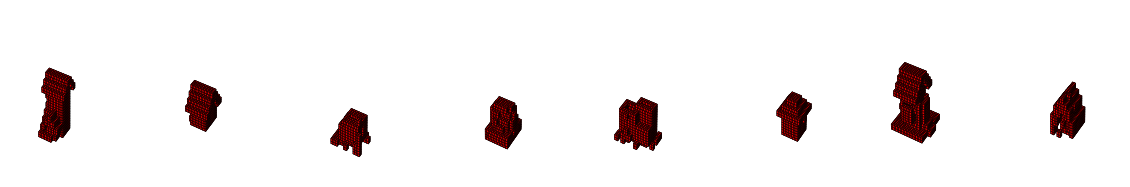

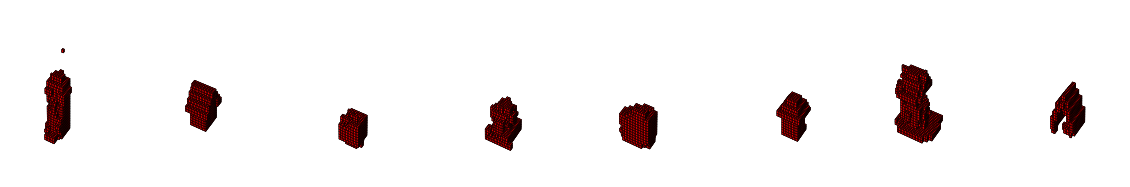

SAMPLE


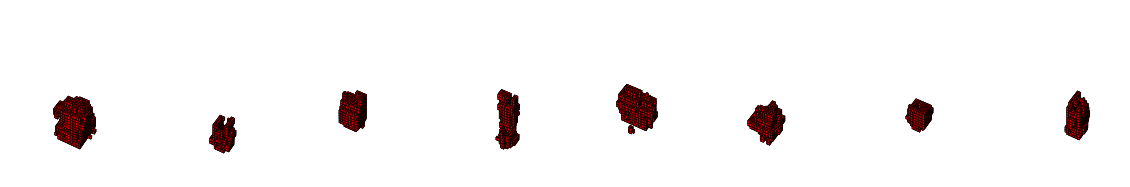

In [40]:
print("RECON")
rand_index = random.choices(list(range(len(X_TRAIN))),k=8)
RAND_SEL = X_TRAIN[rand_index]
reconVAETest(HOUSE_VAE,RAND_SEL)

print("SAMPLE")
generateVAESamples(HOUSE_VAE,zsize=Z_SIZE)

(2, 100)


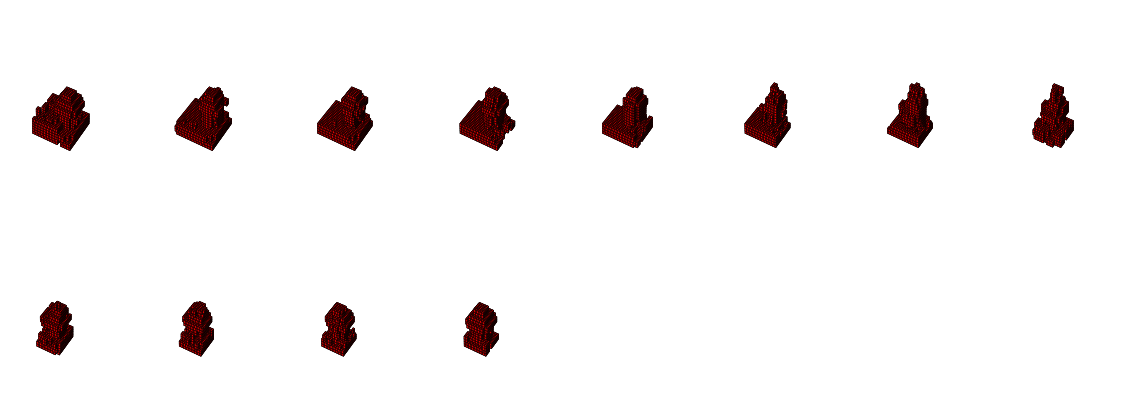

In [54]:
two_houses = X_TRAIN[random.choices(list(range(len(X_TRAIN))),k=2)]
twe = HOUSE_VAE.encoder.predict(two_houses)[2]
print(np.array(two_houses_enc).shape)

diff = twe[1]-twe[0]
inter_houses = [two_houses[0]]
for i in range(0,10,1):
  i2 = i/10
  z = twe[0]+np.array(diff*i2)
  inter_houses.append(np.around(HOUSE_VAE.decoder.predict(np.array([z])).squeeze()))
inter_houses.append(two_houses[1])
show3D(inter_houses)